# Maximum Likelihood Neural Regression

In [1]:
#Modulees

#jax
from jax import jacfwd, vmap
import jax.numpy as jnp
import jax.random as jrandom

#haiku
import haiku as hk

#os
import os

import pandas as pd

#numpy
import numpy as np

import pickle

#matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

#other modules
from load_manifold import get_generator_dim, load_manifold

#scores
from models import neural_regression

#jaxgeometry
from jaxgeometry.statistics.score_matching import model_loader
from jaxgeometry.autodiff import jacfwdx
from jaxgeometry.statistics.score_matching import ScoreEvaluation
from jaxgeometry.manifolds import *

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
2024-05-12 20:14:04.093200: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Hyper Parameters
T = 0.5
score_path = "scores"
s2_approx = 0
s1loss_type = "dsmvr"
s2loss_type = "dsmvr"
s2_type = "s1s2"
seed = 2712

figure_path = '../figures/ml_regression/'
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

In [3]:
def load_mlnr_model(manifold, dim):
    M, x0, sampling_method, generator_dim, layers, opt_val = load_manifold(manifold, dim)
    layers_s1, layers_s2 = layers
    mlnr_path = f"mlnr/{manifold}{dim}/"
    if "Local" in sampling_method:
        method = "Local"
    else:
        method = "Embedded"
    
    if manifold == "Euclidean":
        @hk.transform
        def mlnr_model(x):

            mlnr =  neural_regression.MLP_mlnr_R2(
                neural_regression.MLP_f_R2(dim=generator_dim, layers=layers_s1), 
                neural_regression.MLP_sigma(layers=layers_s1)
                )

            return mlnr(x)
    else:
        @hk.transform
        def mlnr_model(x):

            mlnr =  neural_regression.MLP_mlnr_S2(
                neural_regression.MLP_f_S2(dim=generator_dim, layers=layers_s1), 
                neural_regression.MLP_sigma(layers=layers_s1)
                )

            return mlnr(x)

    rng_key = jrandom.PRNGKey(seed)
    mlnr_state = model_loader.load_model(mlnr_path)
    
    mlnr_fun = lambda x: mlnr_model.apply(mlnr_state.params, rng_key, x)
                       
    return M, x0, mlnr_fun

In [12]:
def load_data(manifold, dim):
    mlnr_path = f"mlnr/{manifold}{dim}/"
    if manifold == "Euclidean":
        input_data = pd.read_csv(''.join((mlnr_path, 'input.csv')), header=None)
        output_data = pd.read_csv(''.join((mlnr_path, 'output.csv')), header=None)
        
        return jnp.array(input_data.values), jnp.array(output_data.values)
    else:
        data_path = '../data/AFLW2000/head_pose.pkl'
        with open(data_path, 'rb') as f:
            data_dict = pickle.load(f)
            
        input_data = jnp.array(data_dict['features'])
        output_data = jnp.array(data_dict['labels'])
        
        return jnp.array(input_data), jnp.array(output_data)

## Testing with $\mathbb{R}^{2}$

In [13]:
M, x0, mlnr_fun = load_mlnr_model("Euclidean", 2)
input_data, output_data = load_data("Euclidean", 2)

using M.Exp for Logarithm


In [14]:
sorted_input = jnp.sort(input_data, axis=0)
f, sigma = mlnr_fun(sorted_input)

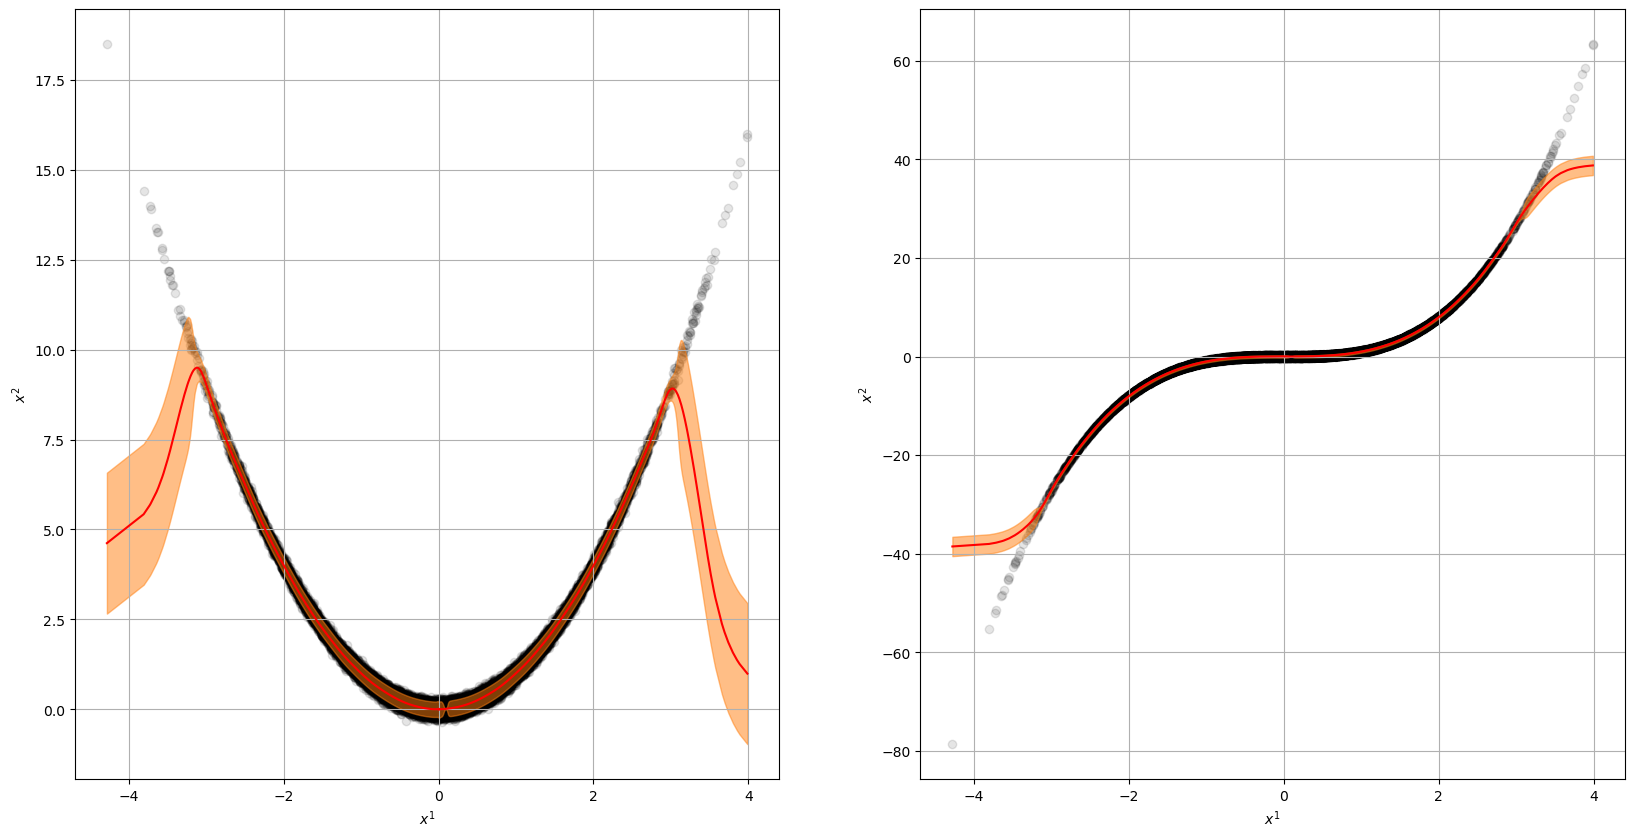

In [15]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121)
ax.plot(sorted_input, f[:,0], color='red')
ax.scatter(input_data,output_data[:,0], color='black', alpha=0.1)
ax.fill_between(
    sorted_input.ravel(),
    f[:,0] - 1.96 * sigma,
    f[:,0] + 1.96 * sigma,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
ax.grid(True)
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')

ax = fig.add_subplot(122)
ax.plot(sorted_input, f[:,1], color='red')
ax.scatter(input_data,output_data[:,1], color='black', alpha=0.1)
ax.fill_between(
    sorted_input.ravel(),
    f[:,1] - 1.96 * sigma,
    f[:,1] + 1.96 * sigma,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
ax.grid(True)
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')

plt.show()


## Application to AFWL2000 Head Position Data

In [16]:
data_path = '../data/AFLW2000/head_pose.pkl'

In [17]:
with open(data_path, 'rb') as f:
    data_dict = pickle.load(f)

In [29]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

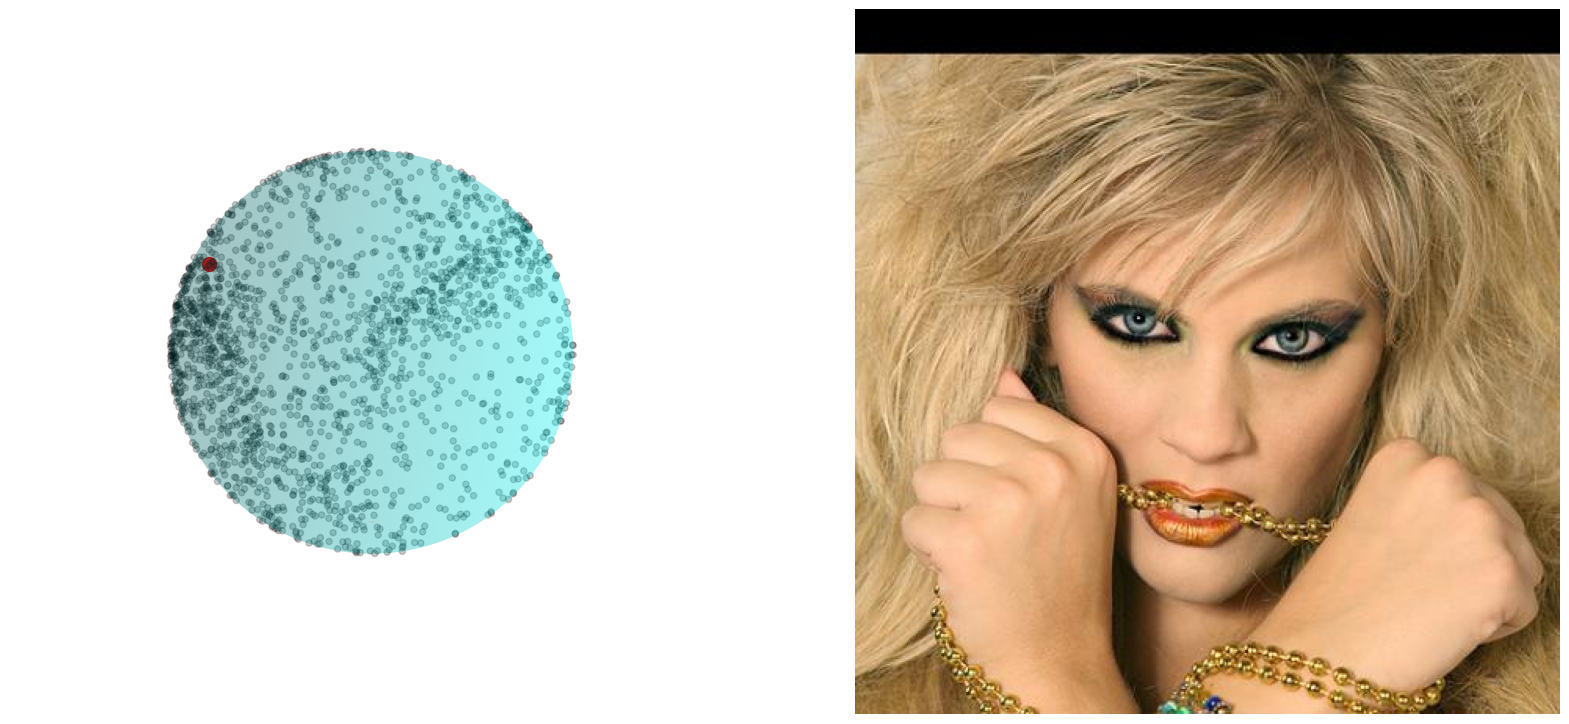

In [18]:
# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals

theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)

# Creating the coordinate grid for the unit sphere.
X1_S2 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2_S2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3_S2 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))

fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X1_S2, X2_S2, X3_S2, rstride=1, cstride=1, color='cyan', alpha=0.2)
ax.scatter(data_dict['labels'][:,0], data_dict['labels'][:,1], data_dict['labels'][:,2], color='black', alpha=0.2)
ax.scatter(data_dict['labels'][0,0], data_dict['labels'][0,1], data_dict['labels'][0,2], color='red', 
           s=100, alpha=1.0)
ax.set_box_aspect([1,1,1])
ax.autoscale(False)
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
#m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
#m.set_array(plot_log_p)
divider = make_axes_locatable(ax)

ax = fig.add_subplot(122)
ax.imshow(data_dict['images'][0], cmap = plt.cm.Spectral)
ax.set_axis_off()
plt.show()


In [19]:
M, x0, mlnr_fun = load_mlnr_model("Sphere", 2)
input_data, output_data = load_data("Sphere", 2)

using M.Exp for Logarithm


In [34]:
f, sigma = mlnr_fun(input_data)

In [35]:
f

Array([[-0.97707766,  0.0449174 ,  0.20809066],
       [ 0.3587507 ,  0.90469843,  0.22982293],
       [-0.19503598,  0.9467786 , -0.25606906],
       ...,
       [-0.2597443 ,  0.9484262 , -0.18171571],
       [-0.8411014 , -0.30262026,  0.4482961 ],
       [-0.08468441, -0.9874172 , -0.1335506 ]], dtype=float32)

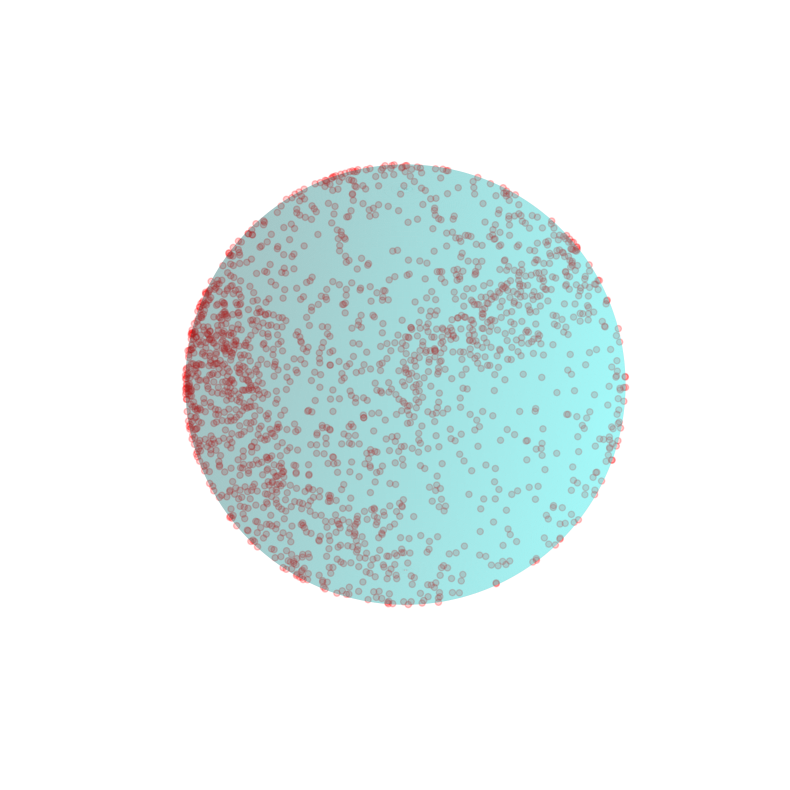

In [36]:
# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals

theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)

# Creating the coordinate grid for the unit sphere.
X1_S2 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2_S2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3_S2 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1_S2, X2_S2, X3_S2, rstride=1, cstride=1, color='cyan', alpha=0.2)
ax.scatter(f[:,0], f[:,1], f[:,2], color='red', alpha=0.2)
ax.set_box_aspect([1,1,1])
ax.autoscale(False)
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
#m = mpl.cm.ScalarMappable(cmap=mpl.cm.inferno)
#m.set_array(plot_log_p)
divider = make_axes_locatable(ax)

plt.show()